In [2]:
reInstall = False

if reInstall == True :
    # Installe PyTorch pour CPU
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    # Installe NumPy et tqdm si nécessaire
    !pip install numpy tqdm scikit-learn matplotlib
    !clear
    print("Installation terminée")
    import torch
    import numpy as np
    from tqdm import tqdm

    print("torch:", torch.__version__)
    print("numpy:", np.__version__)


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

device = torch.device("cpu")
print(f"🔧 Appareil utilisé : {device}")

🔧 Appareil utilisé : cpu


In [4]:
class LuSNARDataset(Dataset):
    def __init__(self, folder_path):
        self.files = sorted([f for f in os.listdir(folder_path) if f.endswith(".npz")])
        self.folder_path = folder_path
        self.label_map = { -1: 0, 0: 1, 174: 2 }

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.files[idx])
        data = np.load(file_path)

        points = data["lidar_points"]  # (N, 3)
        labels = data["lidar_category"]

        num_points = 1024
        if len(points) >= num_points:
            indices = np.random.choice(len(points), num_points, replace=False)
        else:
            indices = np.random.choice(len(points), num_points, replace=True)

        pts = points[indices]
        lbl_raw = labels[indices]
        lbl = np.vectorize(self.label_map.get)(lbl_raw)

        return torch.tensor(pts, dtype=torch.float32), torch.tensor(lbl, dtype=torch.long)


In [5]:
class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp):
        super().__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample

        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

    def forward(self, xyz, points):
        # ici, on ne fait pas de grouping (pas implémenté CPU-only)
        B, N, C = xyz.shape
        new_xyz = xyz[:, :self.npoint, :]  # (B, npoint, 3)
        new_points = points[:, :, None, :]  # (B, D, 1, N)

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))  # (B, D', 1, N)

        new_points = torch.max(new_points, 3)[0]  # global maxpool
        return new_xyz, new_points


In [6]:
class PointNet2Seg(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 256, 1)
        self.bn3 = nn.BatchNorm1d(256)

        self.conv4 = nn.Conv1d(256, 128, 1)
        self.bn4 = nn.BatchNorm1d(128)

        self.dropout = nn.Dropout(0.3)
        self.conv5 = nn.Conv1d(128, num_classes, 1)

    def forward(self, x):  # x : (B, N, 3)
        x = x.transpose(2, 1)  # → (B, 3, N)

        x = F.relu(self.bn1(self.conv1(x)))  # → (B, 64, N)
        x = F.relu(self.bn2(self.conv2(x)))  # → (B, 128, N)
        x = F.relu(self.bn3(self.conv3(x)))  # → (B, 256, N)
        x = F.relu(self.bn4(self.conv4(x)))  # → (B, 128, N)

        x = self.dropout(x)
        x = self.conv5(x)  # → (B, num_classes, N)

        return x.transpose(2, 1).contiguous()  # → (B, N, num_classes)

In [7]:
dataset_path = "data/moon"
batch_size = 8  # réduit pour CPU

full_dataset = LuSNARDataset(dataset_path)
total_size = len(full_dataset)
val_size = int(0.1 * total_size)
test_size = int(0.1 * total_size)
train_size = total_size - val_size - test_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [9]:
from collections import Counter
import numpy as np
import torch

# récupération du dataset complet (LuSNARDataset) associé à train_dataset
base_dataset = train_dataset.dataset
index_map = train_dataset.indices  # indices utilisés pour le split

total_counts = Counter()

for i in index_map:
    file_path = os.path.join(base_dataset.folder_path, base_dataset.files[i])
    arr = np.load(file_path)
    labels = arr["lidar_category"].flatten()
    total_counts.update(labels.tolist())

print("📊 Répartition réelle des classes dans le train :", total_counts)

# remapping comme dans le dataset : {-1 → 0, 0 → 1, 174 → 2}
remap = { -1: 0, 0: 1, 174: 2 }
mapped_counts = Counter()
for raw_label, count in total_counts.items():
    if raw_label in remap:
        mapped_counts[remap[raw_label]] += count

print("🔁 Répartition après remapping :", mapped_counts)

# Création du vecteur de comptage
counts = torch.tensor([mapped_counts.get(i, 0) for i in range(3)], dtype=torch.float)

# ⚠️ Protection contre les 0
counts[counts == 0] = 1e-6

# Pondération inversement proportionnelle
total = counts.sum()
weights = total / counts
weights = weights / weights.sum()  # normalisation stricte

# ➤ Définition de la loss avec pondération
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
print("📈 Poids pondérés utilisés :", weights.tolist())


# ➤ Modèle et optimiseur
model = PointNet2Seg(num_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Répartition réelle des classes dans le train : Counter({-1: 144484587, 174: 19756742, 0: 2332180})
# Répartition après remapping : Counter({0: 144484587, 2: 19756742, 1: 2332180})
# Poids pondérés utilisés : [0.014231681823730469, 0.8816895484924316, 0.10407882928848267]

📊 Répartition réelle des classes dans le train : Counter({-1: 144484587, 174: 19756742, 0: 2332180})
🔁 Répartition après remapping : Counter({0: 144484587, 2: 19756742, 1: 2332180})
📈 Poids pondérés utilisés : [0.014231681823730469, 0.8816895484924316, 0.10407882928848267]


In [ ]:
import copy
num_epochs = 30
best_miou = 0.0
patience = 5
patience_counter = 0
SAVE_PATH = "pointnetpp_best_miou.pt"

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for points, labels in tqdm(train_loader, desc=f"🧪 Epoch {epoch} [train]"):
        points, labels = points.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(points)  # (B, N, C)
        loss = criterion(outputs.view(-1, 3), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # --- validation
    model.eval()
    val_loss = 0
    correct = total = 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for points, labels in val_loader:
            points, labels = points.to(device), labels.to(device)
            outputs = model(points)
            val_loss += criterion(outputs.view(-1, 3), labels.view(-1)).item()
            preds = outputs.argmax(dim=2)
            correct += (preds == labels).sum().item()
            total += labels.numel()
            preds_all.append(preds.cpu().numpy())
            labels_all.append(labels.cpu().numpy())

    val_acc = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader)

    # --- mIoU
    y_true = np.concatenate(labels_all).flatten()
    y_pred = np.concatenate(preds_all).flatten()
    ious = []
    for cls in range(3):
        tp = np.logical_and(y_pred == cls, y_true == cls).sum()
        fp = np.logical_and(y_pred == cls, y_true != cls).sum()
        fn = np.logical_and(y_pred != cls, y_true == cls).sum()
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else float("nan")
        ious.append(iou)
    val_miou = np.nanmean(ious)

    print(f"📊 Epoch {epoch}: train loss={avg_train_loss:.4f} | val loss={avg_val_loss:.4f} | val acc={val_acc:.2f}% | val mIoU={val_miou:.4f}")

    # early stopping
    if val_miou > best_miou:
        best_miou = val_miou
        patience_counter = 0
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"💾 Nouveau meilleur modèle sauvegardé (val mIoU: {best_miou:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


🧪 Epoch 1 [train]: 100%|██████████| 478/478 [01:31<00:00,  5.20it/s]


📊 Epoch 1: train loss=0.4756 | val loss=0.4180 | val acc=79.61% | val mIoU=0.4454
💾 Nouveau meilleur modèle sauvegardé (val mIoU: 0.4454)


🧪 Epoch 2 [train]: 100%|██████████| 478/478 [04:00<00:00,  1.98it/s]


📊 Epoch 2: train loss=0.4208 | val loss=0.4043 | val acc=82.87% | val mIoU=0.4825
💾 Nouveau meilleur modèle sauvegardé (val mIoU: 0.4825)


🧪 Epoch 3 [train]: 100%|██████████| 478/478 [05:12<00:00,  1.53it/s]


📊 Epoch 3: train loss=0.4112 | val loss=0.4011 | val acc=81.09% | val mIoU=0.4586


🧪 Epoch 4 [train]: 100%|██████████| 478/478 [04:05<00:00,  1.95it/s]


📊 Epoch 4: train loss=0.4055 | val loss=0.3893 | val acc=83.19% | val mIoU=0.4802


🧪 Epoch 5 [train]: 100%|██████████| 478/478 [03:47<00:00,  2.10it/s]


📊 Epoch 5: train loss=0.3978 | val loss=0.3893 | val acc=82.54% | val mIoU=0.4747


🧪 Epoch 6 [train]: 100%|██████████| 478/478 [01:42<00:00,  4.67it/s]


📊 Epoch 6: train loss=0.3932 | val loss=0.3846 | val acc=82.03% | val mIoU=0.4679


🧪 Epoch 7 [train]: 100%|██████████| 478/478 [01:43<00:00,  4.60it/s]


📊 Epoch 7: train loss=0.3907 | val loss=0.3790 | val acc=83.78% | val mIoU=0.4881
💾 Nouveau meilleur modèle sauvegardé (val mIoU: 0.4881)


🧪 Epoch 8 [train]: 100%|██████████| 478/478 [01:43<00:00,  4.62it/s]


📊 Epoch 8: train loss=0.3891 | val loss=0.3867 | val acc=83.79% | val mIoU=0.4877


🧪 Epoch 9 [train]: 100%|██████████| 478/478 [01:39<00:00,  4.81it/s]


📊 Epoch 9: train loss=0.3844 | val loss=0.3801 | val acc=84.87% | val mIoU=0.5010
💾 Nouveau meilleur modèle sauvegardé (val mIoU: 0.5010)


🧪 Epoch 10 [train]: 100%|██████████| 478/478 [03:43<00:00,  2.13it/s]


📊 Epoch 10: train loss=0.3817 | val loss=0.3790 | val acc=83.40% | val mIoU=0.4834


🧪 Epoch 11 [train]: 100%|██████████| 478/478 [05:48<00:00,  1.37it/s]


📊 Epoch 11: train loss=0.3813 | val loss=0.3842 | val acc=85.07% | val mIoU=0.5075
💾 Nouveau meilleur modèle sauvegardé (val mIoU: 0.5075)


🧪 Epoch 12 [train]: 100%|██████████| 478/478 [03:51<00:00,  2.06it/s]


📊 Epoch 12: train loss=0.3767 | val loss=0.3807 | val acc=83.09% | val mIoU=0.4803


🧪 Epoch 13 [train]: 100%|██████████| 478/478 [01:44<00:00,  4.58it/s]


📊 Epoch 13: train loss=0.3747 | val loss=0.3927 | val acc=83.47% | val mIoU=0.4862


🧪 Epoch 14 [train]: 100%|██████████| 478/478 [02:55<00:00,  2.73it/s]


📊 Epoch 14: train loss=0.3704 | val loss=0.3847 | val acc=81.81% | val mIoU=0.4679


🧪 Epoch 15 [train]: 100%|██████████| 478/478 [02:27<00:00,  3.23it/s]


In [ ]:
SAVE_PATH = "pointnetpp_best_miou.pt"
torch.save(model.state_dict(), SAVE_PATH)
print("✅ Modèle sauvegardé :", SAVE_PATH)


✅ Modèle sauvegardé : pointnetpp_best_miou.pt


In [ ]:
model = PointNet2Seg(num_classes=3).to(device)
model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
model.eval()
print("📦 Modèle chargé depuis :", SAVE_PATH)


NameError: name 'PointNet2Seg' is not defined

🔍 Rapport par classe :
              precision    recall  f1-score   support

    regolith     0.9779    0.8552    0.9124    425634
      crater     0.1975    0.9088    0.3245      7093
        rock     0.5226    0.7792    0.6256     56745

    accuracy                         0.8471    489472
   macro avg     0.5660    0.8477    0.6208    489472
weighted avg     0.9138    0.8471    0.8706    489472



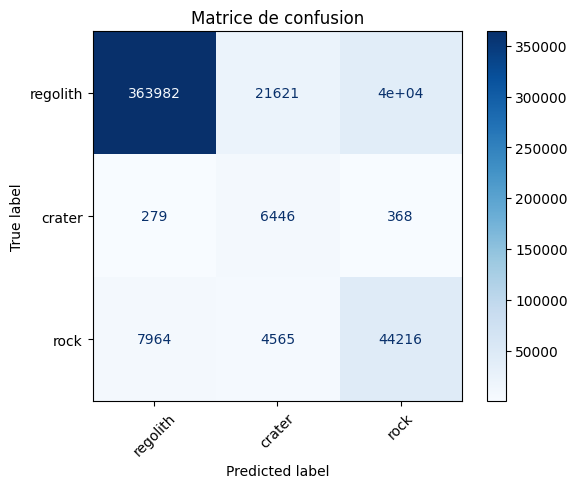

📊 IoU par classe :
 - regolith   : 0.8389
 - crater     : 0.1937
 - rock       : 0.4552

📈 mIoU global : 0.4959


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for points, labels in test_loader:
        points, labels = points.to(device), labels.to(device)
        outputs = model(points)  # (B, N, C)
        preds = outputs.argmax(dim=2)  # (B, N)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_true = np.concatenate(all_labels).flatten()
y_pred = np.concatenate(all_preds).flatten()

# classification
print("🔍 Rapport par classe :")
print(classification_report(
    y_true, y_pred,
    target_names=["regolith", "crater", "rock"],
    digits=4
))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["regolith", "crater", "rock"])
disp.plot(cmap="Blues", xticks_rotation=45)
disp.ax_.set_title("Matrice de confusion")
plt.show()

# mIoU
ious = []
for cls in range(3):
    tp = np.logical_and(y_pred == cls, y_true == cls).sum()
    fp = np.logical_and(y_pred == cls, y_true != cls).sum()
    fn = np.logical_and(y_pred != cls, y_true == cls).sum()
    denom = tp + fp + fn
    iou = tp / denom if denom > 0 else float("nan")
    ious.append(iou)

print("📊 IoU par classe :")
for name, val in zip(["regolith", "crater", "rock"], ious):
    print(f" - {name:10s} : {val:.4f}")
print(f"\n📈 mIoU global : {np.nanmean(ious):.4f}")


C:\Users\theog\AppData\Local\Temp\ipykernel_15784\2206416109.py:31: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\theog\AppData\Local\Temp\ipykernel_15784\2206416109.py:31: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


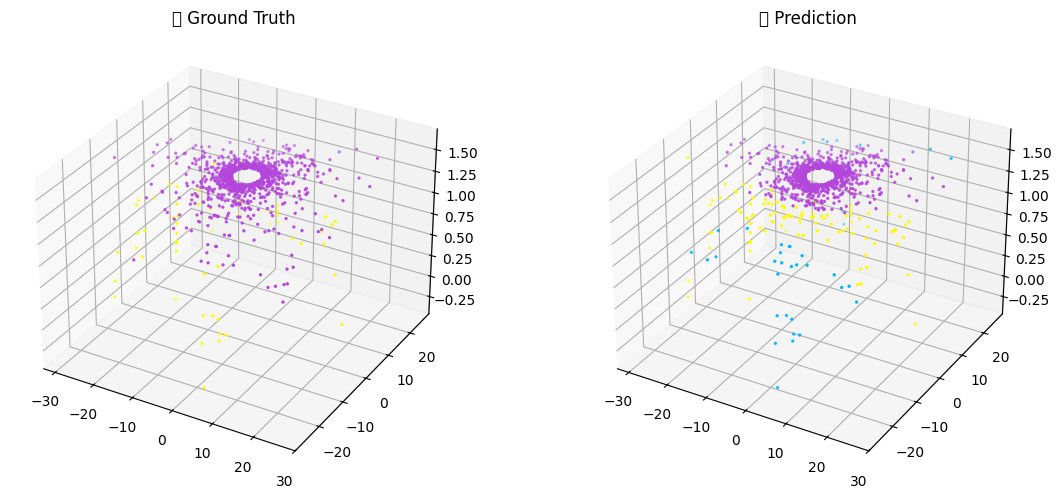

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

points, labels = next(iter(test_loader))
points, labels = points.to(device), labels.to(device)
outputs = model(points)
preds = outputs.argmax(dim=2)

i = 0  # premier échantillon du batch
pc = points[i].cpu().numpy()        # (N, 3)
gt = labels[i].cpu().numpy()        # (N,)
pr = preds[i].cpu().numpy()         # (N,)

colors_map = {
    0: [180, 70, 220],   # regolith
    1: [0, 180, 255],    # crater
    2: [255, 255, 0],    # rock
}
colors_gt = np.array([colors_map[l] for l in gt]) / 255.
colors_pr = np.array([colors_map[l] for l in pr]) / 255.

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("✅ Ground Truth")
ax1.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colors_gt, s=2)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("🔷 Prediction")
ax2.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colors_pr, s=2)

plt.tight_layout()
plt.show()
